In [16]:
import numpy as np
import sys, os
import _maps as maps
import _wavelets as wt

import healpy as hp
import astropy_healpix

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import norm, uniform
from scipy.integrate import quad

from tqdm import tqdm

(-1.0, 1.0)

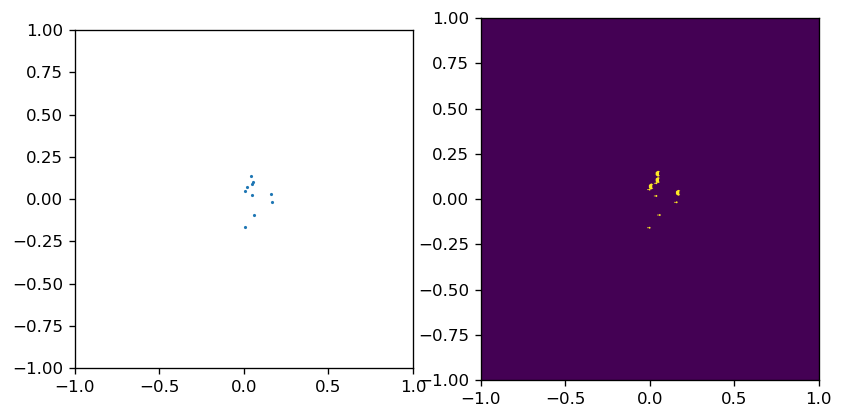

In [17]:
nm = norm(scale = 0.1, loc = 0)
x_data = nm.rvs(size = 10)
y_data = nm.rvs(size = 10)

fig = plt.figure(figsize=(8, 4), dpi= 120)
ax = fig.add_subplot(121)
ax.set_aspect('equal')

ax.scatter(x_data, y_data, s = 0.8)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax = fig.add_subplot(122)
ax.hexbin(x_data,y_data, gridsize = 100, extent = [-1,1,-1,1])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

In [18]:
bx_min, bx_max, by_min, by_max = [-1, 1,
                                  -1, 1]

scale = 0.1
step_size = scale 
mesh_bxby, arr_b, arr_bx_plot, arr_by_plot = maps.build_mesh_(bx_min, bx_max, by_min, by_max, step_size, step_size, return_arrays_for_plotting=True)
arr_bx = 0.5*(arr_bx_plot[1:] + arr_bx_plot[:-1])
arr_by = 0.5*(arr_by_plot[1:] + arr_by_plot[:-1])

(-1.0, 1.0)

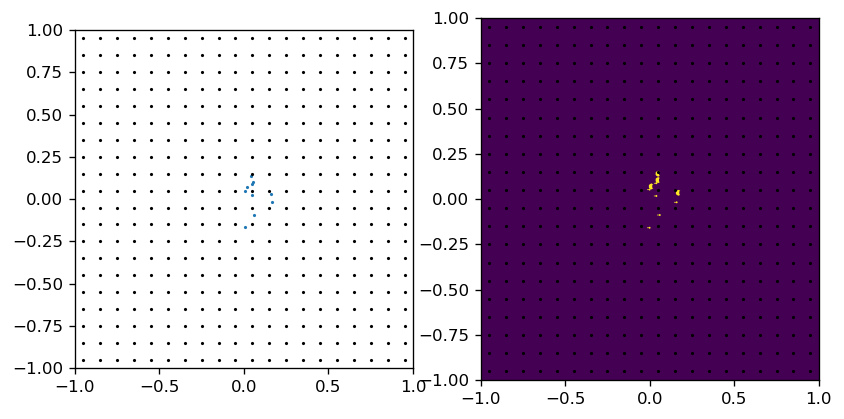

In [19]:
fig = plt.figure(figsize=(8, 4), dpi= 120)
ax = fig.add_subplot(121)
ax.set_aspect('equal')

ax.scatter(x_data, y_data, s = 0.8)
ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.8, c = 'k')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax = fig.add_subplot(122)
ax.hexbin(x_data,y_data, gridsize = 100, extent = [-1,1,-1,1])
ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.8, c = 'k')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

In [20]:
# copy/paste from skysearch/generate_wavelet_coefficients.py

# load scale parameter
a = 0.1
arr_a = np.array([a])
Na = len(arr_a)

# define 2d wavelet
wavelet_name = 'mexh'
mexh = wt._2d_wavelet(wavelet_name)

# pre-allocate wavelet coefficient map 
data = np.stack([x_data, y_data], axis = -1)
N_data, N_dim = data.shape
Ny, Nx = mesh_bxby.shape[:-1]
cwt_map = np.zeros((Ny, Nx, 1))

# broadcast arrays in wavelet calculation
buf_data = data[np.newaxis,np.newaxis,np.newaxis]
buf_mesh_bxby = mesh_bxby[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_a = arr_a[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

# calculate arguments of wavelet coefficients
# buf_grid = grid[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_arg =  ( (buf_data - buf_mesh_bxby ) / buf_arr_a )

# calculate wavelet coefficients
buf_mexh_output = mexh.base_fct(buf_arr_arg)

# remove two dimensions of a-array to divide mexh
buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

# estimate wavelet coefficient by summing over datapoints
buf_cwt_map = np.sum(buf_mexh_output, axis = -1) / buf_arr_a_sq / N_data
buf_cwt_map = np.squeeze(buf_cwt_map, axis = -1)

# copy wavelet coefficient map to output array
cwt_map[:,:,0] = buf_cwt_map[:,:,0]

(-1.0, 1.0)

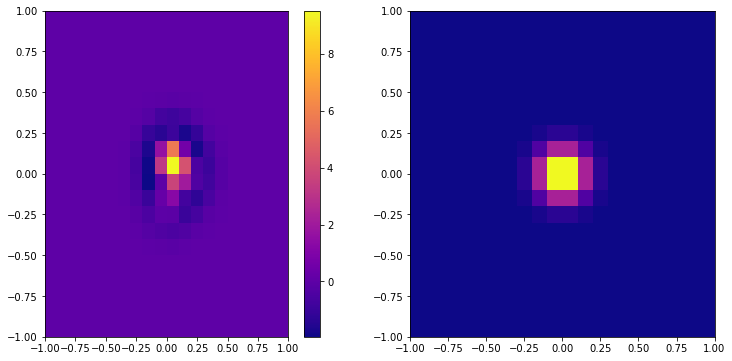

In [21]:
# compare to Gaussian 

# evaluate norm pdf at each grid point
output_pdf = np.zeros((len(arr_bx), len(arr_by)))
for nx in range(len(arr_bx)):
    for ny in range(len(arr_by)):
        output_pdf[nx,ny] = nm.pdf(arr_bx[nx]) * nm.pdf(arr_by[ny]) 

fig = plt.figure(1,figsize=(12,6))
ax = fig.add_subplot(121)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='plasma', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=np.min(cwt_map[:,:,0]), 
                                                 vmax=np.max(cwt_map[:,:,0])))
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.colorbar(plot)

ax = fig.add_subplot(122)
ax.pcolormesh(arr_bx_plot, arr_by_plot, output_pdf, cmap='plasma', shading='flat')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

(-1.0, 1.0)

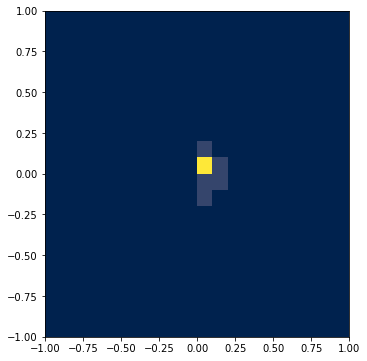

In [22]:
x_data = data[:,0] ; y_data = data[:,1]

fig = plt.figure(1,figsize=(12,6))
ax = fig.add_subplot(121)
counts_array, xedges, yedges, image = ax.hist2d(x_data, y_data, bins = [arr_bx_plot, arr_by_plot], cmap = 'cividis')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

Text(0, 0.5, 'Wavelet Coefficient')

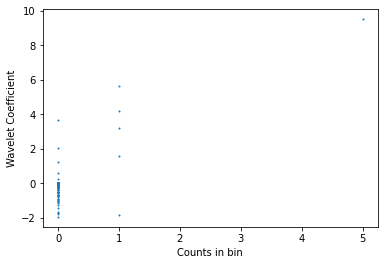

In [23]:
from scipy.stats import gaussian_kde

counts_flat = counts_array.flatten('C')
cwt_flat = cwt_map[:,:,0].flatten('C')

fig, ax = plt.subplots()
ax.scatter(counts_flat, cwt_flat, s = 1)
ax.set_xlabel('Counts in bin')
ax.set_ylabel('Wavelet Coefficient')

(-1.0, 1.0)

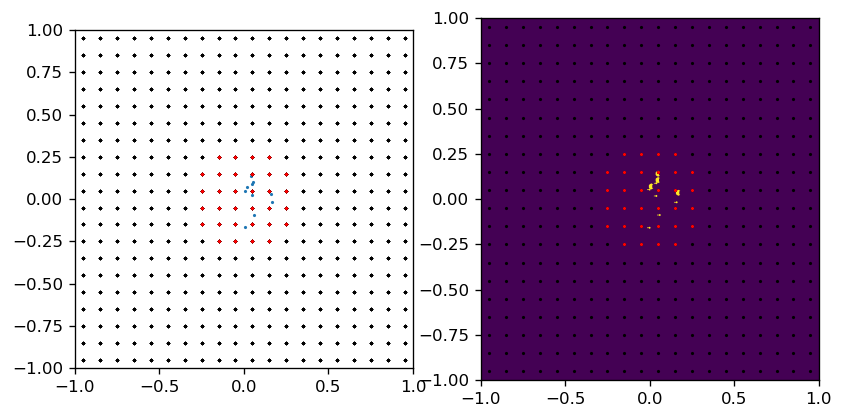

In [24]:
relative_positions = mesh_bxby - np.array([0,0])
distances = np.linalg.norm(relative_positions, axis = -1)
near = ( distances < np.sqrt(0.3**2 + 0.1**2) )

fig = plt.figure(figsize=(8, 4), dpi= 120)
ax = fig.add_subplot(121)
ax.set_aspect('equal')

ax.scatter(x_data, y_data, s = 0.8)
for n in range(Nx):
    ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.8, c = 'k')
    ax.scatter(mesh_bxby[near][:,0], mesh_bxby[near][:,1], s = 0.8, c = 'r')

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax = fig.add_subplot(122)
ax.hexbin(x_data,y_data, gridsize = 100, extent = [-1,1,-1,1])
ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.8, c = 'k')
ax.scatter(mesh_bxby[near][:,0], mesh_bxby[near][:,1], s = 0.8, c = 'r')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

Text(0, 0.5, 'Wavelet Coefficient')

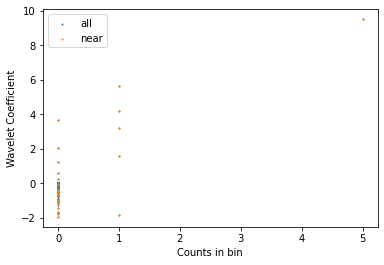

In [25]:
from scipy.stats import gaussian_kde

counts_flat_near = counts_array[near].flatten('C')
cwt_flat_near = cwt_map[:,:,0][near].flatten('C')

fig, ax = plt.subplots()
ax.scatter(counts_flat, cwt_flat, s = 1)
ax.scatter(counts_flat_near, cwt_flat_near, s = 1)
ax.legend(['all', 'near'])
ax.set_xlabel('Counts in bin')
ax.set_ylabel('Wavelet Coefficient')

In [ ]:
nm = norm(scale = 0.1, loc = -0.5)
x_data = nm.rvs(size = 10000)
y_data = nm.rvs(size = 10000)

nm = norm(scale = 0.1, loc = 0.5)
x_data = np.concatenate((x_data, nm.rvs(size = 10000)))
y_data = np.concatenate((y_data, nm.rvs(size = 10000)))

fig = plt.figure(figsize=(8, 4), dpi= 120)
ax = fig.add_subplot(121)
ax.set_aspect('equal')

ax.scatter(x_data, y_data, s = 0.8)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax = fig.add_subplot(122)
ax.hexbin(x_data,y_data, gridsize = 100, extent = [-1,1,-1,1])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

In [ ]:
# copy/paste from skysearch/generate_wavelet_coefficients.py

# load scale parameter
a = 0.1
arr_a = np.array([a])
Na = len(arr_a)

# define 2d wavelet
wavelet_name = 'mexh'
mexh = wt._2d_wavelet(wavelet_name)

# pre-allocate wavelet coefficient map 
data = np.stack([x_data, y_data], axis = -1)
N_data, N_dim = data.shape
Ny, Nx = mesh_bxby.shape[:-1]
cwt_map = np.zeros((Ny, Nx, 1))

# broadcast arrays in wavelet calculation
buf_data = data[np.newaxis,np.newaxis,np.newaxis]
buf_mesh_bxby = mesh_bxby[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_a = arr_a[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

# calculate arguments of wavelet coefficients
# buf_grid = grid[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_arg =  ( (buf_data - buf_mesh_bxby ) / buf_arr_a )

# calculate wavelet coefficients
buf_mexh_output = mexh.base_fct(buf_arr_arg)

# remove two dimensions of a-array to divide mexh
buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

# estimate wavelet coefficient by summing over datapoints
buf_cwt_map = np.sum(buf_mexh_output, axis = -1) / buf_arr_a_sq / N_data
buf_cwt_map = np.squeeze(buf_cwt_map, axis = -1)

# copy wavelet coefficient map to output array
cwt_map[:,:,0] = buf_cwt_map[:,:,0]

In [ ]:
x_data = data[:,0] ; y_data = data[:,1]

fig = plt.figure(1,figsize=(12,6))
ax = fig.add_subplot(121)
counts_array, xedges, yedges, image = ax.hist2d(x_data, y_data, bins = [arr_bx_plot, arr_by_plot], cmap = 'cividis')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

In [ ]:
from scipy.stats import gaussian_kde

counts_flat = counts_array.flatten('C')
cwt_flat = cwt_map[:,:,0].flatten('C')

fig, ax = plt.subplots()
ax.scatter(counts_flat, cwt_flat, s = 1)

In [ ]:
# sample data from normal distribution 
N_data = 100

Ng = 50
# N_scales = uniform.rvs(size = Ng)
log_scales = -2 * uniform.rvs(size = Ng) - 2
scales = 10**log_scales
#scales = 0.05 * uniform.rvs(size = Ng)
N_scales = np.array([int(scale**0.5 * N_data) for scale in scales])
locs_x = 1.8 * uniform.rvs(size = Ng) - 0.9 
locs_y = 1.8 * uniform.rvs(size = Ng) - 0.9 

x_gauss = []
y_gauss = []
for n in range(Ng):
    nm_small_x = norm(scale = scales[n], loc = locs_x[n])
    nm_small_y = norm(scale = scales[n], loc = locs_y[n])
    x_data_small = nm_small_x.rvs(size = int(N_scales[n] * N_data))
    y_data_small = nm_small_y.rvs(size = int(N_scales[n] * N_data))
    x_gauss = np.concatenate((x_gauss, x_data_small))
    y_gauss = np.concatenate((y_gauss, y_data_small))

plt.scatter(x_gauss, y_gauss, s = 0.8)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [ ]:
# copy/paste from skysearch/generate_wavelet_coefficients.py

# load scale parameter
a = 0.1
arr_a = np.array([a])
Na = len(arr_a)

# define 2d wavelet
wavelet_name = 'mexh'
mexh = wt._2d_wavelet(wavelet_name)

# pre-allocate wavelet coefficient map 
data = np.stack([x_gauss, y_gauss], axis = -1)
N_data, N_dim = data.shape
Ny, Nx = mesh_bxby.shape[:-1]
cwt_map = np.zeros((Ny, Nx, 1))

# broadcast arrays in wavelet calculation
buf_data = data[np.newaxis,np.newaxis,np.newaxis]
buf_mesh_bxby = mesh_bxby[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_a = arr_a[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

# calculate arguments of wavelet coefficients
# buf_grid = grid[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_arg =  ( (buf_data - buf_mesh_bxby ) / buf_arr_a )

# calculate wavelet coefficients
buf_mexh_output = mexh.base_fct(buf_arr_arg)

# remove two dimensions of a-array to divide mexh
buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

# estimate wavelet coefficient by summing over datapoints
buf_cwt_map = np.sum(buf_mexh_output, axis = -1) / buf_arr_a_sq / N_data
buf_cwt_map = np.squeeze(buf_cwt_map, axis = -1)

# copy wavelet coefficient map to output array
cwt_map[:,:,0] = buf_cwt_map[:,:,0]

In [ ]:
x_data = data[:,0] ; y_data = data[:,1]

fig = plt.figure(1,figsize=(12,6))
ax = fig.add_subplot(121)
counts_gauss, xedges, yedges, image = ax.hist2d(x_gauss, y_gauss, bins = [arr_bx_plot, arr_by_plot], cmap = 'cividis')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

In [ ]:
from scipy.stats import gaussian_kde

counts_flat = counts_gauss.flatten('C')
cwt_flat = cwt_map[:,:,0].flatten('C')

fig, ax = plt.subplots()
ax.scatter(counts_flat, cwt_flat, s = 1)

In [26]:
# calculate cwt for a faint point source and see how it is related to number of counts

cwt_map_list = []
counts_list = []
cwt_flat_near_list = []
counts_flat_near_list = []

for n in range(10000):
    nm = norm(scale = 0.1, loc = 0)
    x_data = nm.rvs(size = 10)
    y_data = nm.rvs(size = 10)

    # load scale parameter
    a = 0.1
    arr_a = np.array([a])
    Na = len(arr_a)

    # define 2d wavelet
    wavelet_name = 'mexh'
    mexh = wt._2d_wavelet(wavelet_name)

    # pre-allocate wavelet coefficient map 
    data = np.stack([x_data, y_data], axis = -1)
    N_data, N_dim = data.shape
    Ny, Nx = mesh_bxby.shape[:-1]
    cwt_map = np.zeros((Ny, Nx, 1))

    # broadcast arrays in wavelet calculation
    buf_data = data[np.newaxis,np.newaxis,np.newaxis]
    buf_mesh_bxby = mesh_bxby[:,:,np.newaxis,np.newaxis,np.newaxis]
    buf_arr_a = arr_a[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    # calculate arguments of wavelet coefficients
    # buf_grid = grid[:,:,np.newaxis,np.newaxis,np.newaxis]
    buf_arr_arg =  ( (buf_data - buf_mesh_bxby ) / buf_arr_a )

    # calculate wavelet coefficients
    buf_mexh_output = mexh.base_fct(buf_arr_arg)

    # remove two dimensions of a-array to divide mexh
    buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
    buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

    # estimate wavelet coefficient by summing over datapoints
    buf_cwt_map = np.sum(buf_mexh_output, axis = -1) / buf_arr_a_sq / N_data
    buf_cwt_map = np.squeeze(buf_cwt_map, axis = -1)

    # copy wavelet coefficient map to output array
    cwt_map[:,:,0] = buf_cwt_map[:,:,0]
    cwt_map_list.append(cwt_map)

    x_data = data[:,0] ; y_data = data[:,1]
    counts, xedges, yedges = np.histogram2d(x_data, y_data, bins = [arr_bx_plot, arr_by_plot])
    counts_list.append(counts)

    cwt_flat_near = cwt_map[:,:,0][near].flatten('C')
    counts_flat_near = counts[near].flatten('C')

    cwt_flat_near_list.append(cwt_flat_near)
    counts_flat_near_list.append(counts_flat_near)

In [27]:
for n in tqdm(range(10000)):
    cwt_map = cwt_map_list[n]
    counts = counts_list[n]

    counts_flat = counts.flatten('C')
    cwt_flat = cwt_map[:,:,0].flatten('C')

    cwt_flat_near = cwt_flat_near_list[n]
    counts_flat_near = counts_flat_near_list[n]

    if n == 0:
        counts_flat_list = counts_flat
        cwt_flat_list = cwt_flat
        counts_flat_near_single = counts_flat_near
        cwt_flat_near_single = cwt_flat_near
    else:
        counts_flat_list = np.concatenate((counts_flat_list, counts_flat))
        cwt_flat_list = np.concatenate((cwt_flat_list, cwt_flat))
        counts_flat_near_single = np.concatenate((counts_flat_near_single, counts_flat_near))
        cwt_flat_near_single = np.concatenate((cwt_flat_near_single, cwt_flat_near))

100%|██████████| 10000/10000 [02:40<00:00, 62.27it/s]


Text(0, 0.5, 'Wavelet Coefficient')

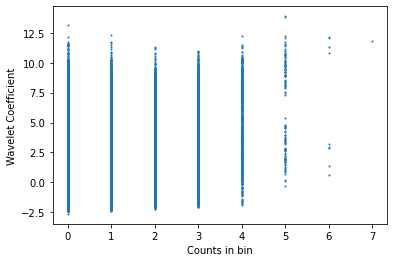

In [28]:
from scipy.stats import gaussian_kde

counts_flat = counts_array.flatten('C')
cwt_flat = cwt_map[:,:,0].flatten('C')

fig, ax = plt.subplots()
ax.scatter(counts_flat_list, cwt_flat_list, s = 1)
ax.set_xlabel('Counts in bin')
ax.set_ylabel('Wavelet Coefficient')

(array([1.000000e+00, 8.000000e+00, 9.600000e+01, 3.470000e+02,
        1.143000e+03, 2.763000e+03, 5.657000e+03, 1.037800e+04,
        1.643100e+04, 2.307100e+04, 3.035100e+04, 3.904500e+04,
        5.066900e+04, 6.663300e+04, 9.257600e+04, 1.338800e+05,
        3.369779e+06, 9.007000e+03, 7.876000e+03, 7.001000e+03,
        6.146000e+03, 5.501000e+03, 4.803000e+03, 4.241000e+03,
        3.645000e+03, 3.223000e+03, 2.920000e+03, 2.506000e+03,
        2.434000e+03, 2.122000e+03, 1.980000e+03, 1.806000e+03,
        1.612000e+03, 1.507000e+03, 1.363000e+03, 1.258000e+03,
        1.153000e+03, 1.052000e+03, 9.600000e+02, 8.960000e+02,
        8.220000e+02, 7.070000e+02, 6.600000e+02, 5.870000e+02,
        5.370000e+02, 4.830000e+02, 4.280000e+02, 3.660000e+02,
        3.630000e+02, 3.170000e+02, 3.050000e+02, 2.590000e+02,
        2.530000e+02, 2.450000e+02, 1.600000e+02, 1.760000e+02,
        1.750000e+02, 1.140000e+02, 1.270000e+02, 1.050000e+02,
        9.600000e+01, 8.700000e+01, 7.10

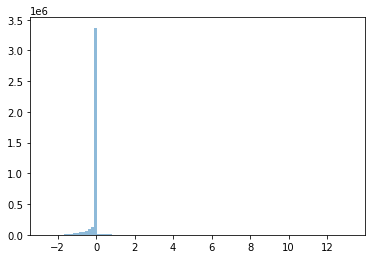

In [29]:
plt.hist(cwt_flat_list[counts_flat_list==0], bins = 100, density = False, alpha = 0.5)

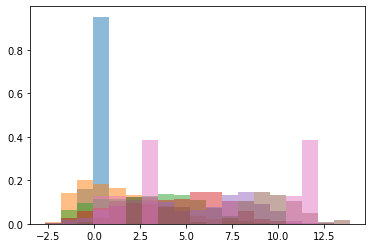

In [30]:
cwt_bins = np.linspace(np.min(cwt_flat_list), np.max(cwt_flat_list), 20)

cwt_flat_n_list = []
cwt_flat_list_binned = []
for n in range(int(np.max(counts_flat_list))):
    cwt_flat_n = cwt_flat_list[counts_flat_list==n]
    cwt_flat_n_list.append(cwt_flat_n)
    cwt_counts, bins, _ = plt.hist(cwt_flat_n, bins = cwt_bins, density = True, alpha = 0.5)
    cwt_flat_list_binned.append(cwt_counts)

Number of Data Points within Each Group:
----------------------------------------
Counts in Bin: [0 1 2 3 4 5 6]
Number of Data Points: [3925822   54217   15133    3936     762     120       9]


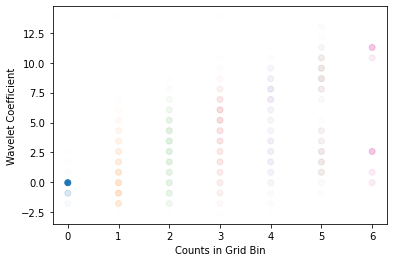

In [31]:
fig, ax = plt.subplots()

for n in range(int(np.max(counts_flat_list))):
    counts_flat_n = counts_flat_list[counts_flat_list==n]
    ax.scatter(n * np.ones(len(cwt_bins)), cwt_bins, alpha = cwt_flat_list_binned[n] / np.max(cwt_flat_list_binned), label = str(n))
    ax.set_xlabel('Counts in Grid Bin')
    ax.set_ylabel('Wavelet Coefficient')

print('Number of Data Points within Each Group:')
print('----------------------------------------')
print('Counts in Bin: ' + str(np.arange(int(np.max(counts_flat_list)))))
print('Number of Data Points: ' + str(np.array([len(counts_flat_list[counts_flat_list==n]) for n in range(int(np.max(counts_flat_list)))])))

Text(0, 0.5, 'Wavelet Coefficient')

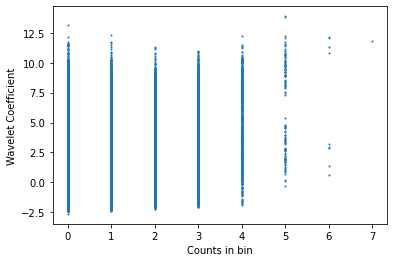

In [32]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots()
ax.scatter(counts_flat_near_single, cwt_flat_near_single, s = 1)
ax.set_xlabel('Counts in bin')
ax.set_ylabel('Wavelet Coefficient')

(array([1.0000e+00, 1.3000e+01, 1.4000e+02, 5.5200e+02, 1.6810e+03,
        3.9670e+03, 8.0520e+03, 1.3805e+04, 2.0727e+04, 2.5906e+04,
        2.8113e+04, 2.5634e+04, 2.0361e+04, 1.4991e+04, 1.1937e+04,
        1.0554e+04, 9.5000e+03, 9.1710e+03, 8.4470e+03, 7.8630e+03,
        7.2410e+03, 6.5040e+03, 5.9740e+03, 5.3610e+03, 4.8790e+03,
        4.6390e+03, 4.2620e+03, 4.0270e+03, 3.7560e+03, 3.5660e+03,
        3.3520e+03, 3.0900e+03, 2.9470e+03, 2.8240e+03, 2.5740e+03,
        2.5190e+03, 2.2810e+03, 2.2330e+03, 2.0880e+03, 1.9070e+03,
        1.7680e+03, 1.7380e+03, 1.5580e+03, 1.4840e+03, 1.3930e+03,
        1.2740e+03, 1.2620e+03, 1.1750e+03, 1.0930e+03, 1.0010e+03,
        9.2300e+02, 8.6800e+02, 7.2800e+02, 7.4700e+02, 6.0800e+02,
        5.9400e+02, 5.1800e+02, 4.8000e+02, 4.0400e+02, 3.9800e+02,
        3.2300e+02, 3.0900e+02, 2.8500e+02, 2.3200e+02, 1.9100e+02,
        1.6700e+02, 1.5000e+02, 1.2700e+02, 1.0800e+02, 1.1100e+02,
        8.8000e+01, 8.2000e+01, 5.4000e+01, 5.50

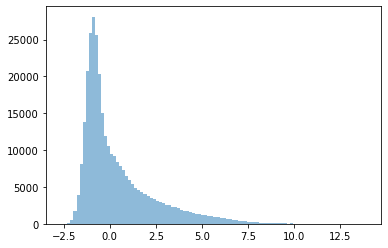

In [33]:
plt.hist(cwt_flat_near_single, bins = 100, density = False, alpha = 0.5)

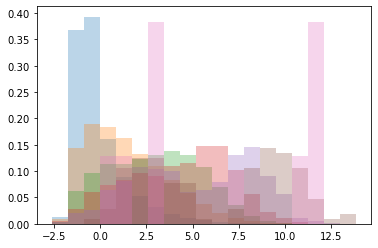

In [36]:
cwt_near_bins = np.linspace(np.min(cwt_flat_near_single), np.max(cwt_flat_near_single), 20)

cwt_flat_near_n_list = []
cwt_flat_near_list_binned = []
for n in range(int(np.max(counts_flat_near_single))):
    cwt_flat_near_n = cwt_flat_near_single[counts_flat_near_single==n]
    cwt_flat_n_list.append(cwt_flat_near_n)
    cwt_near_counts, bins, _ = plt.hist(cwt_flat_near_n, bins = cwt_near_bins, density = True, alpha = 0.3)
    cwt_flat_near_list_binned.append(cwt_near_counts)

Number of Data Points within Each Group:
----------------------------------------
Counts in Bin: [0 1 2 3 4 5 6]
Number of Data Points: [3925822   54217   15133    3936     762     120       9]


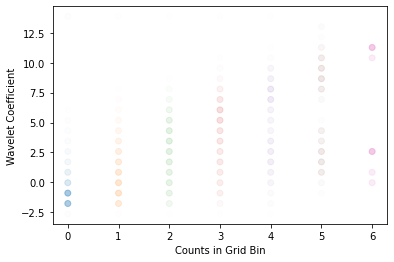

In [37]:
fig, ax = plt.subplots()

for n in range(int(np.max(counts_flat_list))):
    cwt_flat_near_n = cwt_flat_near_single[counts_flat_near_single==n]
    ax.scatter(n * np.ones(len(cwt_near_bins)), cwt_near_bins, alpha = cwt_flat_near_list_binned[n], label = str(n))
    ax.set_xlabel('Counts in Grid Bin')
    ax.set_ylabel('Wavelet Coefficient')

print('Number of Data Points within Each Group:')
print('----------------------------------------')
print('Counts in Bin: ' + str(np.arange(int(np.max(counts_flat_list)))))
print('Number of Data Points: ' + str(np.array([len(counts_flat_list[counts_flat_list==n]) for n in range(int(np.max(counts_flat_list)))])))

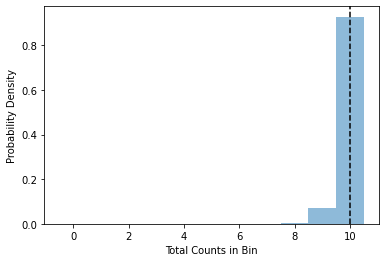

In [38]:
total_counts_list = []
for n in range(10000):
    counts_flat_near = counts_flat_near_list[n]
    total_counts_list.append(np.sum(counts_flat_near))

plt.hist(total_counts_list, bins = np.arange(-0.5,10.5+1,1), density = True, alpha = 0.5)
plt.xlabel('Total Counts in Bin')
plt.ylabel('Probability Density')
plt.axvline(x = 10, color = 'k', linestyle = '--')

In [ ]:
# But, we are interested in the wavelet coefficients in the vicinity of the Gaussian
# So, we should only consider the wavelet coefficients in the vicinity of the Gaussian
# This is better for us. The way that we can define the probability of a source having N
# counts is by this very probability distribution. However, it will depend on the morphology
# and number of datapoints surrounding the point source. In the end, we will have to
# perform tests to assign a probability of how often we obtain the right distribution given
# this probabilistic model.

# If we fail too many times doing things like this, it may be best to employ an ML
# algorithm for classifying the number of datapoints making up a point source.

# We want to make the wavelet coefficient as independent as possible of 
# these hyperparameters like the overall normalization of the dataset.

# Another option is to use one wavelet map for the point source's position itself
# Then, use new wavelet maps on the positions of the point sources to produce
# an estimate of the number of datapoints that it makes up. By doing this for point sources
# injected in the background, we are not assuming empty background or uniform background.

In [ ]:
# cwt_bin_centers = (cwt_bins[1:] + cwt_bins[:-1])/2

# fig, ax = plt.subplots()

# for n in range(int(np.max(counts_flat_list))):
#     counts_flat_n = counts_flat_list[counts_flat_list==n]
#     cwt_flat_n = cwt_flat_list[counts_flat_list==n]
#     bin_closest_to_point = np.argmin(np.abs(cwt_bin_centers - cwt_flat_n))
#     ax.scatter(counts_flat_list[counts_flat_list==n], cwt_flat_list[counts_flat_list==n], cmap = 'cividis', alpha = )
#     ax.set_xlabel('Counts in bin')
#     ax.set_ylabel('Wavelet Coefficient')